In [131]:
import pickle
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import collections
import pandas as pd
from os import listdir
from os.path import isfile, join

In [132]:
from models.contextuals import ContextualEmbeddingModel
from sentence_transformers import SentenceTransformer
from models.baseline import TfidfBaseline, LSABaseline, BaselineWord2Vec, BaselineGloVe
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering


def compute_clusters(file_path:str="../../data/datasud.json",save_path:str = "clusters",nb_clusters_min : int = 5,nb_clusters_max: int = 30):
    file_name = file_path.split("/")[-1].split(".")[0]

    models = []
    models += [
        (KMeans(n_clusters=i), f"km_{i}")
        for i in range(nb_clusters_min, nb_clusters_max + 1)
    ]
    models += [
        (AgglomerativeClustering(n_clusters=i), f"ac_{i}")
        for i in range(nb_clusters_min, nb_clusters_max + 1)
    ]
    models += [
        (SpectralClustering(n_clusters=i), f"sc_{i}")
        for i in range(nb_clusters_min, nb_clusters_max + 1)
    ]

    # TFIDF
    tfidf = TfidfBaseline(file_path)
    tfidf.compute(500)

    # LSA
    lsa = LSABaseline(file_path)
    lsa.compute(500)

    # SBert
    embedder = SentenceTransformer("all-MiniLM-L6-v2")
    sbert = ContextualEmbeddingModel(file_path, embedder)
    sbert.compute_embedding(device="cuda")

    # Word2Vec
    word2vec = BaselineWord2Vec(file_path)
    word2vec.load_and_prepare()

    # GloVe
    path_to_embeddings = "../../vectors_w2v.txt"
    glove = BaselineGloVe(file_path,path_to_embeddings)
    glove.load_and_prepare()

    reprensations = [
        (tfidf, "tfidf"),
        (lsa, "lsa"),
        (sbert, "sbert"),
        (word2vec, "word2vec"),
        (glove, "glove"),
    ]

    for model, model_name in models:
        for repr, repr_name in reprensations:
            if repr_name == "word2vec" and model_name.startswith(
                "sc"
            ):  # Pour une raison obscure, SpectralClustering refuse de fonctionner avec word2vec
                continue
            print(f"Treating : {repr_name}_clusters_{file_name}_{model_name}")
            clusters = repr.kmean_clustering(model)
            with open(
                fr"{save_path}/{repr_name}_clusters_{file_name}_{model_name}.pkl",
                "wb",
            ) as output_file:
                pickle.dump(clusters, output_file)

Pour calculer les clusters.

In [133]:
# compute_clusters()

In [134]:
def extract_gold(file_path: str):

    with open(file_path, encoding="utf8") as f:
        datas = json.load(f)

    group_gold = {}
    datasets = datas["datasets"]

    for d in datasets:
        group_gold[d["dataset_name"]] = d["metadata"]["groups"]

    return group_gold

# Analyse et visualisation sur la répartition des groupes

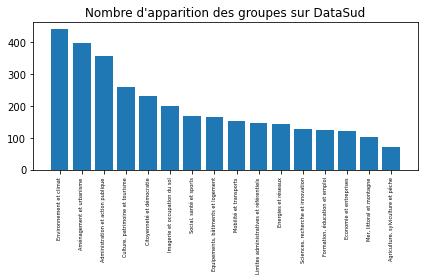

In [135]:
file_path = "../../data/datasud.json"
group_gold = extract_gold(file_path)
c = collections.Counter()
for g_value in group_gold.values():
    c.update(g_value)
c = c.most_common()

_, ax = plt.subplots()
ax.tick_params(axis="x", labelsize=5)
plt.title(f"Nombre d\'apparition des groupes sur DataSud")
plt.xticks(rotation="vertical")
plt.bar([c[0] for c in c], [c[1] for c in c])
plt.tight_layout()
plt.show()

Counter({1: 861, 2: 600, 0: 258, 3: 202, 4: 69, 7: 17, 5: 14, 6: 3, 13: 2, 14: 1, 15: 1, 8: 1})


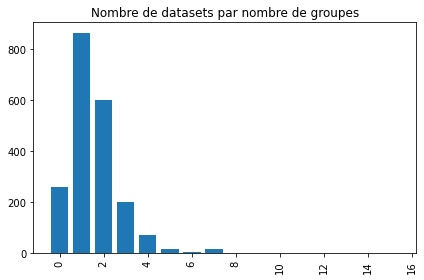

In [136]:
len_c = collections.Counter(list(map(len,group_gold.values())))

print(len_c)
_, ax = plt.subplots()
plt.title(f"Nombre de datasets par nombre de groupes")
plt.xticks(rotation="vertical")
plt.bar(len_c.keys(), len_c.values())
plt.tight_layout()
plt.show()

# Extraction des données gold et alignement avec les données prédites

In [137]:
def get_groups_len(file_path,l) :

    with open(f"{file_path}", "rb") as input_file:
        clusters = pickle.load(input_file)

    gold = []
    pred = []

    le =  preprocessing.LabelEncoder()
    all_group = list({x for l in group_gold.values() for x in l})
    le.fit(all_group)

    for dataset,groups in group_gold.items() :
        if len(groups) == l :
            gold.append(le.transform(groups)[0])
            pred.append(clusters[dataset])

    return gold,pred

# Calcul des différents scores

In [138]:
from sklearn.metrics.cluster import homogeneity_completeness_v_measure, pair_confusion_matrix, contingency_matrix
from sklearn.metrics import rand_score, fowlkes_mallows_score

def evaluate_clusters(gold,pred,k, show=False,repr = "",model =""):
    rand = rand_score(gold,pred)
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(gold,pred)
    fowlkes_mallows = fowlkes_mallows_score(gold,pred)
    pair_confusion = pair_confusion_matrix(gold,pred)
    contingency = contingency_matrix(gold, pred)
    purity = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

    if show :
        print(f"For {len(gold)} datas :")
        print(f"Rand index = {rand}")
        #A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
        print(f"Homogeneity = {homogeneity}") #
        #A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
        print(f"Completeness = {completeness}")
        #The V-measure is the harmonic mean between homogeneity and completeness:
        print(f"V measure = {v_measure}")
        #The Fowlkes-Mallows score FMI is defined as the geometric mean of the pairwise precision and recall
        print(f"Fowlkes-Mallows = {fowlkes_mallows}")
        #To compute purity , each cluster is assigned to the class which is most frequent in the cluster, and then the accuracy of this assignment is measured by counting the number of correctly assigned documents and dividing by N.
        print(f"Purity = {purity}")
        sns.heatmap(pair_confusion, annot=True).set_title("Pair Confusion Matrix")

    return {"representation" : repr,"model" : model, "nb_k" : k,"homogeneity" : homogeneity,"completeness" : completeness,"v_measure" : v_measure,"fowlkes_mallows" : fowlkes_mallows,"purity":purity}

In [139]:
all_results = []

In [140]:
nb_clusters_min = 5
nb_clusters_max = 30
path = "clusters"

decode_model = {"ac" : "Agglomerative Clustering", "km" : "KMeans", "sc" : "Spectral Clustering" }
cluster_files = [f for f in listdir(path) if isfile(join(path, f))]

for cluster_file in cluster_files :
    name_split = cluster_file.split("_")
    reprensation = (name_split[0])
    model = (name_split[3])
    nb_k = (name_split[4].split(".")[0])
    group_len_1_gold, group_len_1_pred = get_groups_len(join(path, cluster_file),1)
    all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,int(nb_k),repr=reprensation, model=decode_model[model]))

In [141]:
import seaborn as sns
df = pd.DataFrame(all_results)

In [142]:
def sns_per_reprensentation(repr,df):
    df_repre = df[df.representation == repr]
    models = set(df_repre.model)
    mesures = ["homogeneity","completeness","v_measure","fowlkes_mallows","purity"]
    i = 0
    fig, axes = plt.subplots(1,len(models), figsize=(len(models)*5,4))
    fig.suptitle(f"Scores by number of cluster for {repr}", fontsize=16, y=1.05)
    for model in models :
        ylabel = " "
        if i == 0 :
            ylabel = "Score"

        df_model = df_repre[df_repre.model == model]
        ymin = np.min([list(getattr(df_repre,mesure)) for mesure in mesures])
        ymax = np.max([list(getattr(df_repre,mesure)) for mesure in mesures])
        for mesure in mesures :
            sns.lineplot(x="nb_k", y=mesure, data=df_model,sort=True,ax = axes[i]).set(title=f"{model}", ylabel=ylabel,ylim=(ymin,ymax+(0.02/(ymax-ymin))))
        i+=1

    axes[-1].legend(title='Mesures', loc='upper left', labels=mesures,bbox_to_anchor=(1.1, 1.05))
    plt.show()

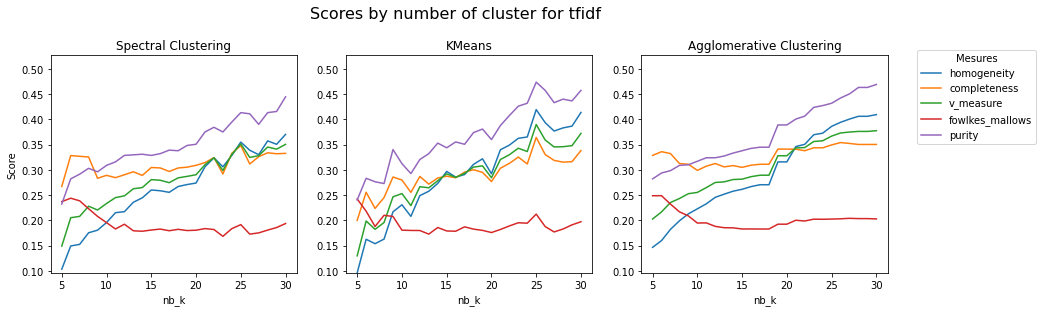

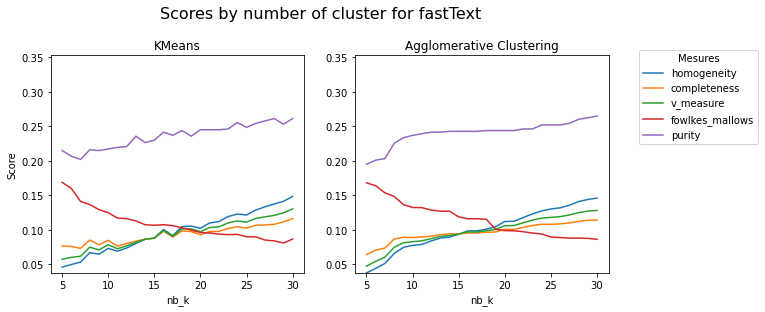

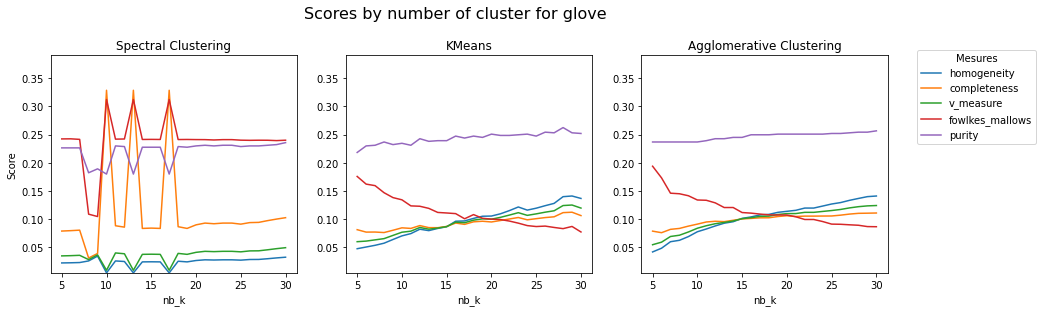

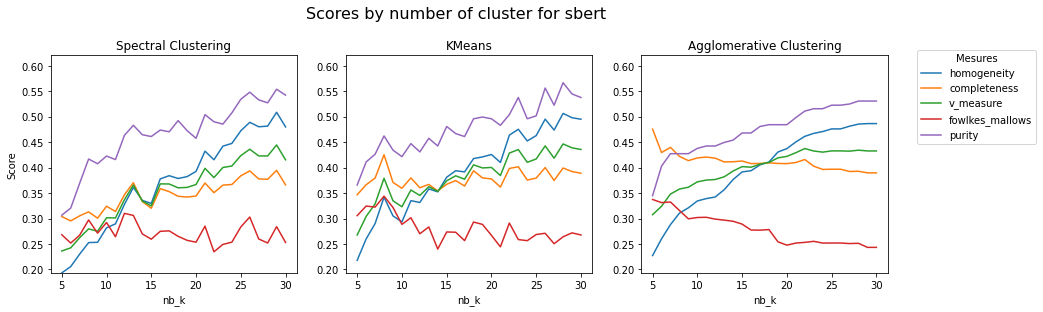

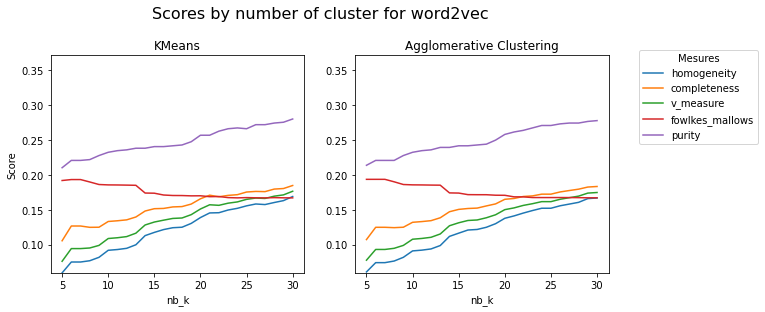

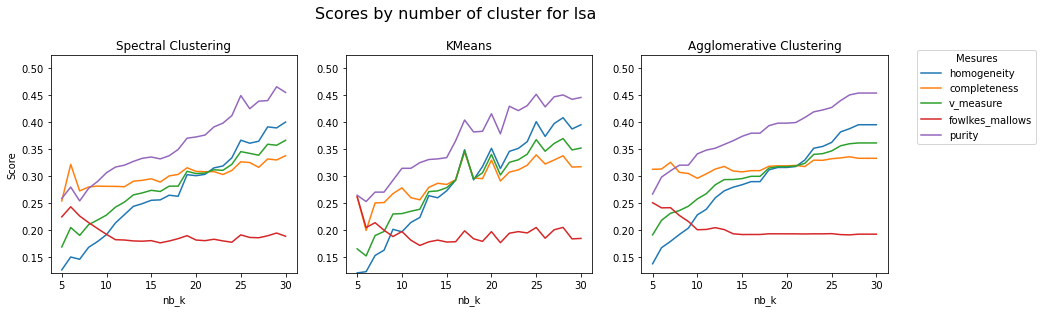

In [143]:
for repr in set(df.representation):
    sns_per_reprensentation(repr,df)

In [144]:
def sns_per_model(model,df):
    df_model = df[df.model == model]
    reprs = set(df_model.representation)
    mesures = ["homogeneity","completeness","v_measure","fowlkes_mallows","purity"]
    i = 0
    fig, axes = plt.subplots(1,len(reprs), figsize=(len(reprs)*5,4))
    fig.suptitle(f"Scores by number of cluster for {model}", fontsize=16, y=1.05)
    for repr in reprs :
        ylabel = " "
        if i == 0 :
            ylabel = "Score"

        df_repr = df_model[df_model.representation == repr]
        ymin = np.min([list(getattr(df_model,mesure)) for mesure in mesures])
        ymax = np.max([list(getattr(df_model,mesure)) for mesure in mesures])
        for mesure in mesures :
            sns.lineplot(x="nb_k", y=mesure, data=df_repr,sort=True,ax = axes[i]).set(title=f"{repr}", ylabel=ylabel,ylim=(ymin,ymax+(0.02/(ymax-ymin))))
        i+=1

    axes[-1].legend(title='Mesures', loc='upper left', labels=mesures,bbox_to_anchor=(1.1, 1.05))
    plt.show()

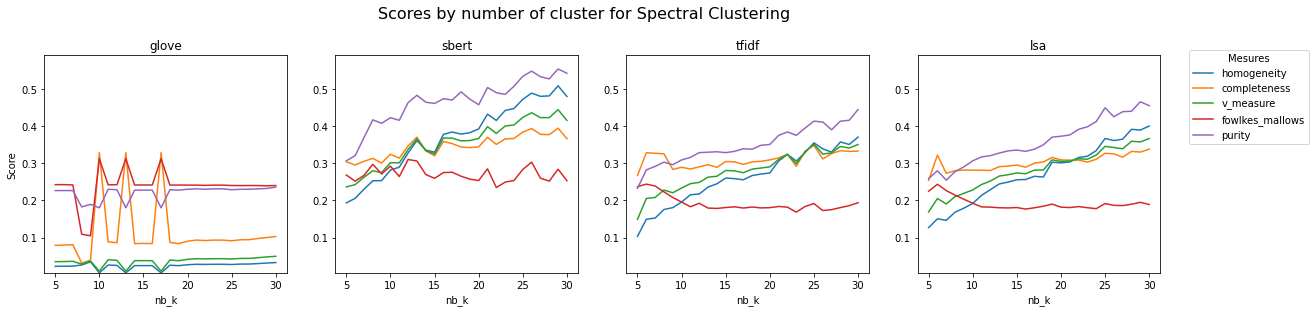

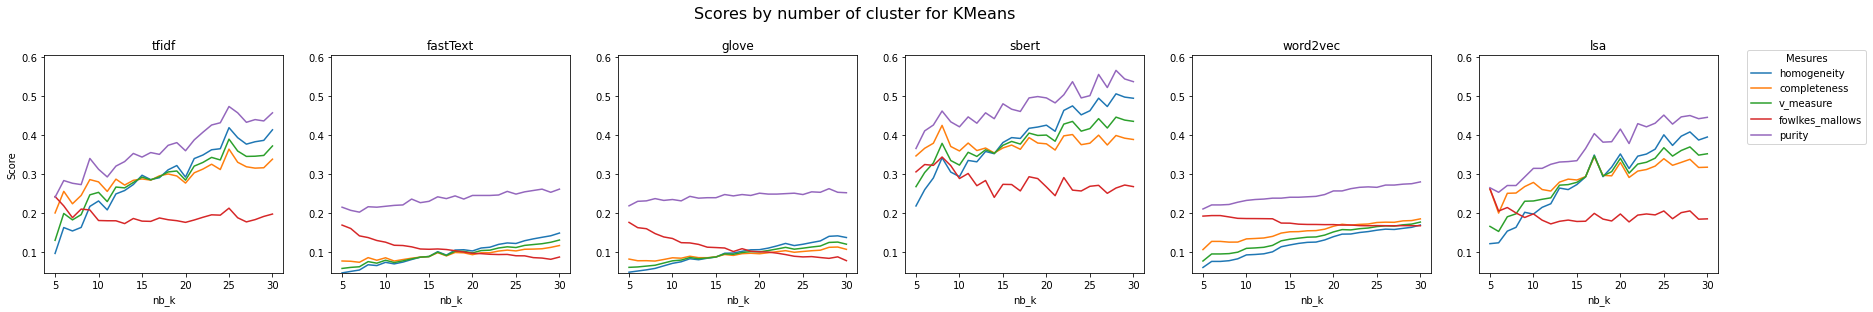

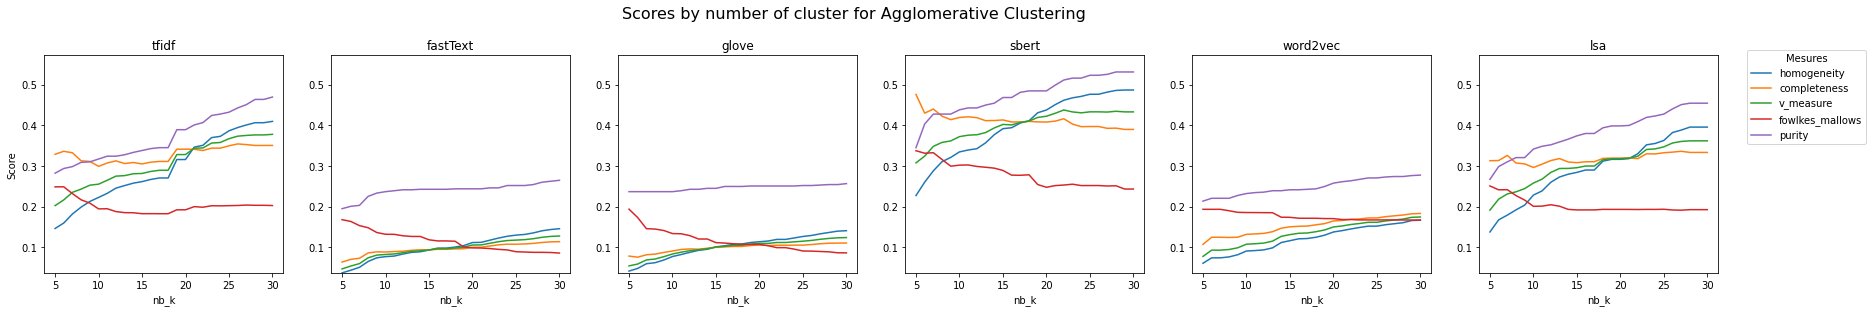

In [145]:
for model in set(df.model):
    sns_per_model(model,df)

In [146]:
def sns_per_measure(model,df):
    df_model = df[df.model == model]
    reprs = set(df_model.representation)
    mesures = ["homogeneity","completeness","v_measure","fowlkes_mallows","purity"]
    nb_k = df.nb_k
    i = 0
    fig, axes = plt.subplots(1,len(mesures), figsize=(len(mesures)*5,4))
    fig.suptitle(f"Scores by number of cluster for {model}", fontsize=16, y=1.05)

    for mesure in mesures :
        ylabel = " "
        if i == 0 :
            ylabel = "Score"

        ymin = np.min([list(getattr(df_model,mesure)) for mesure in mesures])
        ymax = np.max([list(getattr(df_model,mesure)) for mesure in mesures])
        for repr in reprs :
            df_repre = df_model[df_model.representation == repr]
            y = getattr(df_repre,mesure)
            sns.lineplot(x=nb_k, y=y,sort=True,ax = axes[i]).set(title=f"{mesure}", ylabel=ylabel,ylim=(ymin,ymax+(0.02/(ymax-ymin))))
        i+=1

    axes[-1].legend(title='Representation', loc='upper left', labels=reprs,bbox_to_anchor=(1.1, 1.05))
    plt.show()

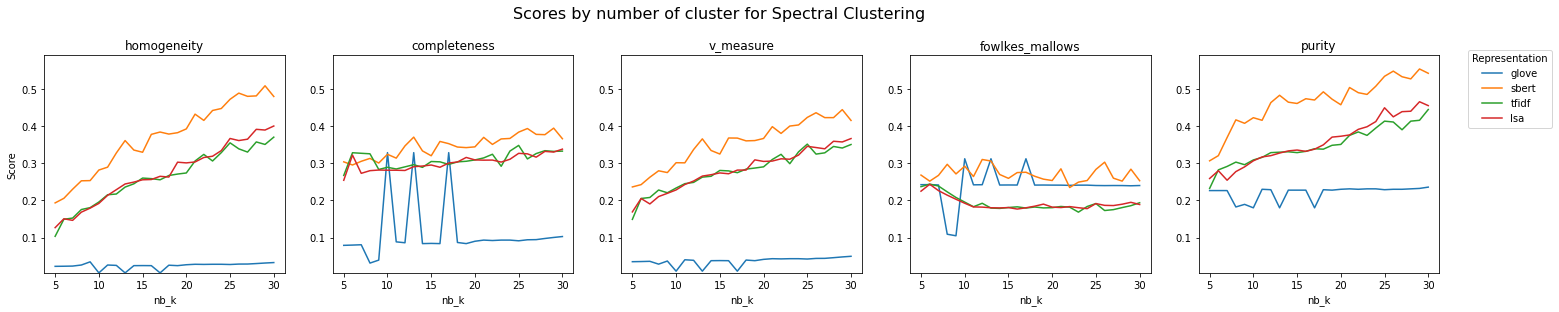

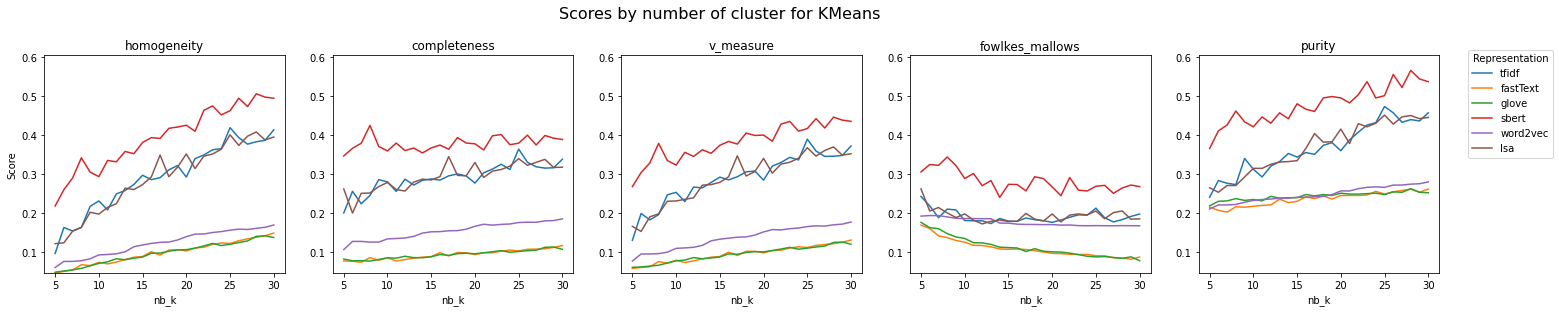

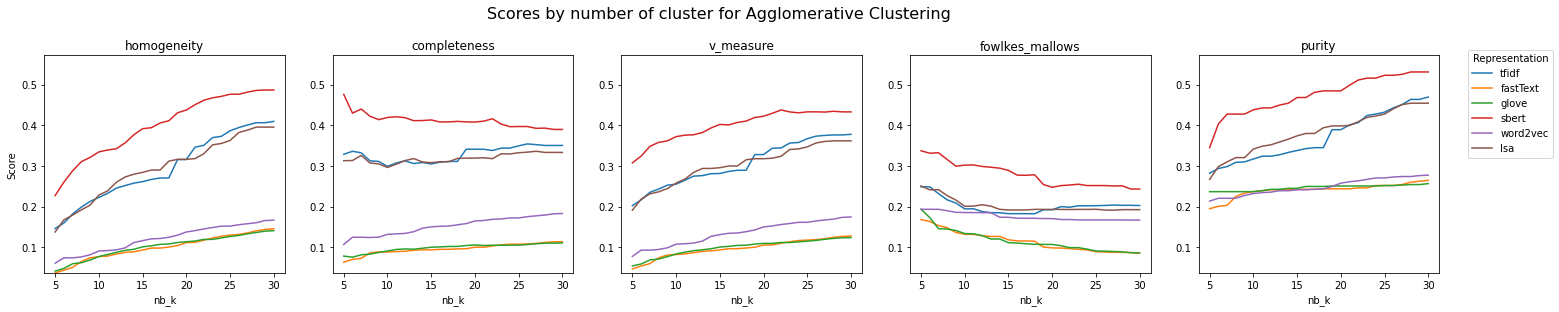

In [147]:
for model in set(df.model):
    sns_per_measure(model,df)